## Investigating summary statistics

In [3]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as extract_sumstats
#from summary_features.calculate_summary_features import calculate_summary_stats_temporal as extract_sumstats



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## defining neuronal network model

from utils.simulation_wrapper import event_seed, set_network_default, simulation_wrapper,simulation_wrapper_obs

sim_wrapper = simulation_wrapper_obs

net = set_network_default()

In [5]:
window_len = 30
prior_min = [7.9, 43.8,  89.49] 

prior_max = [30, 79.9, 152.96]

prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'

number_stats = 10

In [7]:

assert (prior.event_shape==torch.Size([3]))
from utils import inference

In [13]:
from utils import inference
from utils.simulation_wrapper import event_seed, simulation_wrapper
import pickle
from data_load_writer import load_from_file as lf

import os

print(os.getcwd())


os.chdir('..')

print(os.getcwd())



## loading simulations from previously saved computations
file = "code/results/ERP_sequential_3params/step3"
experiment_name = 'notebook_sum_stats_500sim_3params'

  
    


thetas = torch.load('{}/thetas.pt'.format(file))
x_without = torch.load('{}/obs_without.pt'.format(file))

x = extract_sumstats(x_without, number_stats)

true_params = lf.load_true_params(file_writer.folder)

/home/ubuntu/sbi_for_eeg_data/notebooks
/home/ubuntu/sbi_for_eeg_data


UnpicklingError: invalid load key, 'v'.

## Inference step:

In [ ]:
density_estimator = 'nsf'



inf = SNPE(prior=prior, density_estimator = density_estimator)

#inf = SNPE_C(prior, density_estimator="nsf")

inf = inf.append_simulations(thetas, x)


density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)


true_params = torch.tensor([[26.61, 63.53,  137.12]])

## Save in file

In [ ]:
num_samples = 100
file_writer = write_to_file.WriteToFile(
    experiment=experiment_name,
    num_sim='from previous',
    true_params=true_params,
    density_estimator='nsf',
    num_params=2,
    num_samples=num_samples,
    )

os.mkdir('results/{}/step1'.format(experiment_name))


file_writer.save_posterior(posterior)
file_writer.save_observations(x, name='step1')

file_writer.save_thetas(thetas, name='step1')

## Simulation under 'true parameters'

In [ ]:
obs_real = inference.run_only_sim(true_params, sim_wrapper)

obs_real = extract_sumstats(obs_real[0], number_stats)
samples = posterior.sample((num_samples,), x=obs_real[0])


### sample from prior now
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

## Plot simulations from prior samples and compare with simulations from posterior samples

In [ ]:

## simulations from prior samples and posterior samples
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers)
s_x = inference.run_only_sim(samples, sim_wrapper, num_workers)

fig1, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    plt.plot(s, alpha=0.1, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)
plt.plot(obs_real[0], label='Ground truth', color='red')
#plt.legend()



fig2, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in s_x_prior:
    plt.plot(x_w, alpha=0.1, color='blue')

fig1.savefig('results/{}/from_posterior_samples.png'.format(experiment_name))
fig2.savefig('results/{}/from_prior_samples.png'.format(experiment_name))

## Histogram plots

In [ ]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,10*len(s_x_stat[0])), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0])+1, 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.5, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')

# Second part: Optional comparison to embedding network:

## Instead of using hand-crafted summary statistics, one can also use a DNN 

CNNs apply convolutions that can be seen as a slided filter over the time series.
The output is another univariate time series (where the filter has been applied)
As we e.g. have 6 output channels, we apply 6 filters that are able to learn different discriminative, relevant features.

But how do we learn 'the right/discrimative' filters without a discriminator?

In [82]:
#### using a CNN to extract summary statistics

from torch import nn
import torch.nn.functional as F 

class SummaryNet(nn.Module): 

    def __init__(self): 
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # maxpooling reduces length of time series
        self.pool = nn.MaxPool2d(kernel_size=5, stride=5)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=6*17*16, out_features=8) 

    def forward(self, x):
        x = x.view(-1, 1, 80, 85)
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6*17*16)
        x = F.relu(self.fc(x))
        return x

embedding_net = SummaryNet()


# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='nsf', 
                                      embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=2)


In [83]:
window_len, scaling_factor = 30, 3000

In [84]:
from sbi.inference import SNPE_C


# setup the inference procedure with the SNPE-C procedure

inf = SNPE(prior=prior, density_estimator=neural_posterior)

#inf = SNPE_C(prior, density_estimator="nsf")

inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 22 epochs.


In [72]:
x.shape

torch.Size([500, 6800])

In [85]:
from data_load_writer import write_to_file

import os
experiment_name = 'cnn_sum_stats_500sim_2params'
true_params = [26.6, 63.53]

#os.mkdir('results')


num_samples = 100
file_writer = write_to_file.WriteToFile(
    experiment=experiment_name,
    num_sim=number_simulations,
    true_params=true_params,
    density_estimator='nsf',
    num_params=2,
    num_samples=num_samples,
    )

os.mkdir('results/{}/step1'.format(experiment_name))


file_writer.save_posterior(posterior)
file_writer.save_observations(x, name='step1')

file_writer.save_obs_without(x_without, name='step1')
file_writer.save_thetas(theta, name='step1')


In [86]:
true_params = torch.tensor([[26.6, 63.53]])
obs_real = inference.run_only_sim(true_params, sim_wrapper)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.0s finished


In [75]:
obs_real[0][0:6800].shape

torch.Size([6800])

In [87]:

#obs_real_stats = extract_sumstats(obs_real[0], number_stats)

#obs_real_stats = embedding_net.forward(obs_real[0][0:6800])


print(obs_real_stats)

samples = posterior.sample((num_samples,), x=obs_real[0][0:6800])


samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

tensor([[  0.0000,   5.1465, 389.1545,   0.0000,  77.3184, 121.8759, 489.8614,
         172.2554]], grad_fn=<ReluBackward0>)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [88]:
from joblib import Parallel, delayed

num_workers = 8
#x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = inference.run_only_sim(samples, sim_wrapper, num_workers)

2
22params size
2 params size
 
torch.Size([2])2torch.Size([2])
params size 22


params size
params size2params size torch.Size([2])
torch.Size([2])

params size  torch.Size([2])torch.Size([2])

 params sizetorch.Size([2])
 torch.Size([2])
2 params are investigated2 params are investigated
2 params are investigatedjoblib will run over 1 jobs


2 params are investigatedjoblib will run over 1 jobsjoblib will run over 1 jobs


2 params are investigated2 params are investigatedjoblib will run over 1 jobs

joblib will run over 1 jobsjoblib will run over 1 jobs


2 params are investigated
joblib will run over 1 jobs
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
[Done]
running trial 1 on 1 cores


Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 130.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 120.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
2
params size to

Building the NEURON model
Simulation time: 120.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 120.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 140.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 150.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 10.0 ms...
Simulation time: 160.0 ms...
Simulation time: 60.0 ms...
Simulation time: 150.0 ms...
Simulation time: 60.0 ms...
Simulation time: 150.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 20.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  7.3min


Building the NEURON model
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
Simulation time: 40.0 ms...
Simulation time: 120.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
Simulation time: 50.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
Simulation time: 130.0 ms...
[Parallel(n_jobs=8)]: Done  58 tasks      | elapsed: 11.7min
Simulation time: 150.0 ms...
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 60.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 10.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 40.0 ms...
2
params size torch.Size([2])
2 params are investigated


running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 20.0 ms...
Simulation time: 40.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 140.0 ms...
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 140.0 ms...
Simulation time: 10.0 ms...
Simulation time: 100.0 ms...
Simulation time: 30.0 ms...
Simulation time: 50.0 ms...
Simulation time: 10.0 ms...
Simulation time: 150.0 ms...
Simulation time: 20.0 ms...
Simulation time: 150.0 ms...
Simulation time: 20.0 ms...
Simulation time: 110.0 ms...
Simulation time: 40.0 ms...
Simulation time: 60.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 160.0 ms...
Simulation time: 30.0 ms...
Simulation time: 160.0 ms...
Simulation time: 120.0 ms...
Simulation time: 50.0 ms...
Simulation time: 70.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
Simulation time: 40.0 ms...
[Paral

Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 60.0 ms...
Simulation time: 100.0 ms...
Simulation time: 50.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 70.0 ms...
Simulation time: 110.0 ms...
Simulation time: 60.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 10.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 70.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 20.0 ms...
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 30.

In [89]:
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers)

222
2params size
params size

 params size22params size 22
 torch.Size([2])
torch.Size([2]) 

torch.Size([2])torch.Size([2])params size
params size
 params size  torch.Size([2])torch.Size([2])


params size torch.Size([2])torch.Size([2])


2 params are investigated2 params are investigated
2 params are investigated

joblib will run over 1 jobsjoblib will run over 1 jobs

joblib will run over 1 jobs2 params are investigated

2 params are investigatedjoblib will run over 1 jobs2 params are investigated

2 params are investigated

joblib will run over 1 jobsjoblib will run over 1 jobs

2 params are investigatedjoblib will run over 1 jobs

joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
Building the NEURON modelBuilding the NEURON model

Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
[Done][Done][Done]

running trial 

Simulation time: 160.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  19 tasks      | elapsed:  4.7min
Simulation time: 160.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
Building the NEURON model[Parallel(n_jobs=8)]: Done  20 tasks      | elapsed:  4.7min

Building the NEURON model
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed:  4.7min
Building the NEURON model
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  22 tasks      | elapsed:  4.7min
2
params size Building the NEURON modeltorch.Size([2])

2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  23 t

running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 160.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 160.0 ms...
Simulation time: 10.0 ms...
2
params sizeSimulation time: 150.0 ms... 
torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  43 tasks      | elapsed:  9.3min
Building the NEURON model
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  44 tasks      | elapsed:  9.3min
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Building the NEURON model
Simulation time: 150.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  9.4min
Building the NEURON model
Simulation time: 20.0 ms...
Simulation time: 160.0 ms...
2
params size torch.Size([2])
2 params are investigat

Simulation time: 0.03 ms...
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 130.0 ms...
Simulation time: 30.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 140.0 ms...
Simulation time: 10.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 40.0 ms...
Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 20.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  67 tasks      | elapsed: 14.0min
Building the NEURON model
Simulation time: 150.0 ms...
Simulation time: 50.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  68 tasks      | elapsed: 14.1min
Simulation time: 30.0 m

Simulation time: 140.0 ms...
Simulation time: 60.0 ms...
Simulation time: 120.0 ms...
Simulation time: 10.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 150.0 ms...
Simulation time: 70.0 ms...
Simulation time: 150.0 ms...
Simulation time: 120.0 ms...
Simulation time: 20.0 ms...
Simulation time: 130.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 160.0 ms...
Simulation time: 80.0 ms...
Simulation time: 160.0 ms...
Simulation time: 130.0 ms...
Simulation time: 30.0 ms...
Simulation time: 140.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
2
params size torch.Size([2])
2 params are investigated
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  91 out of 100 | elapsed: 18.7min remaining:  1.9min
Building the NEURON model
Simulation time: 90.0 ms...
2
params size torch.Size([2])
Simulation time: 140.0 ms...
2 params are investigated
joblib will run over 1 jobs
Simulation time: 40.0 ms...
Building 

In [90]:
s_x_torch = torch.stack(([s_x[i] for i in range(len(s_x))]))

s_x_prior_torch = torch.stack(([s_x_prior[i] for i in range(len(s_x_prior))]))

print(s_x_torch.dim())

2


In [91]:
s_x_stat = extract_sumstats(s_x_torch, number_stats)

s_x_prior_stat = extract_sumstats(s_x_prior_torch, number_stats)


print(s_x_stat.shape)


torch.Size([100, 6801])
torch.Size([100, 341])
torch.Size([100, 6801])
torch.Size([100, 341])
torch.Size([100, 341])


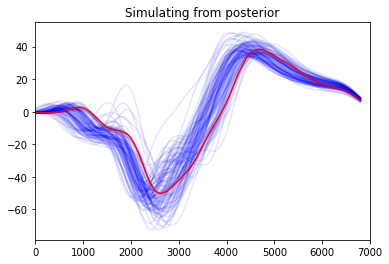

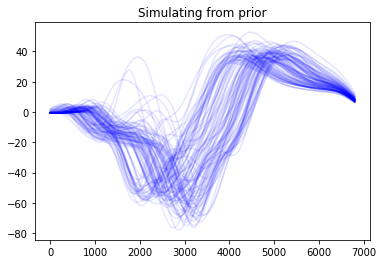

In [92]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    plt.plot(s, alpha=0.1, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)
plt.plot(obs_real[0], label='Ground truth', color='red')
#plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in s_x_prior:
    plt.plot(x_w, alpha=0.1, color='blue')

341
tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

IndexError: index 8 is out of bounds for dimension 0 with size 8

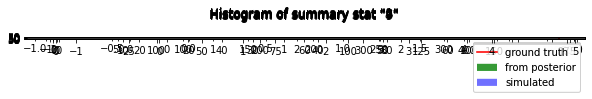

In [95]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,10*len(s_x_stat[0])), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0])+1, 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.5, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')

In [ ]:
print(obs_real_stats.shape)

In [ ]:
true_params = torch.Tensor([26.6, 63.53])




fig, axes = analysis.pairplot(samples,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');